## AirBnB Project
In this project we are going to make a model for giving us insights on the price of an AirBnB in New York **(NY)** in America, with this dataset from kaggle.

For the Column that we will be using is as follows:
- neighbourhood
- neighbourhood group
- room type 
- price
- construction year
- availability 365
- minimum nights


By making the model we can make an interactive dashboard for user to interact with via streamlit.


Here is the Dataset Link: https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata?resource=download


In [1]:
# importing the necesarry libraries

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random #this is for the visual color

# Preprocessing and model utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor  # Changed from Classifier to Regressor
import xgboost as xgb

### Knowing the Dataset

In [2]:
data = pd.read_csv("Airbnb_Open_Data.csv")
data.head()

/tmp/ipykernel_20105/1113942449.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Airbnb_Open_Data.csv")


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [4]:
# Now we're going to see if theres any null/missing values and duplicate 
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_summary = pd.DataFrame({
    'Column': data.columns,
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_summary[missing_summary['Missing Percentage'] > 0])

Missing Values Summary:
                                                        Column  Missing Count  \
license                                                license         102597   
house_rules                                        house_rules          52131   
last review                                        last review          15893   
reviews per month                            reviews per month          15879   
country                                                country            532   
availability 365                              availability 365            448   
minimum nights                                  minimum nights            409   
host name                                            host name            406   
review rate number                          review rate number            326   
calculated host listings count  calculated host listings count            319   
host_identity_verified                  host_identity_verified            289   
serv

In [5]:
# Clean 'price' column before filling missing values
if 'price' in data.columns:
    data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
    
# Fill numeric missing values with median
for col in ['price', 'Construction year', 'availability 365', 'minimum nights']:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert price if it's object
    data[col].fillna(data[col].median(), inplace=True)

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_20105/1206382065.py:3: SyntaxWarning: invalid escape sequence '\$'
  data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipykernel_20105/1206382065.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [6]:
# Drop rows with missing categorical values
data.dropna(subset=['neighbourhood', 'neighbourhood group', 'room type'], inplace=True)

In [7]:
data.isna().sum()

id                                     0
NAME                                 248
host id                                0
host_identity_verified               281
host name                            405
neighbourhood group                    0
neighbourhood                          0
lat                                    8
long                                   8
country                              529
country code                         128
instant_bookable                     102
cancellation_policy                   73
room type                              0
Construction year                      0
price                                  0
service fee                          273
minimum nights                         0
number of reviews                    183
last review                        15889
reviews per month                  15877
review rate number                   324
calculated host listings count       319
availability 365                       0
house_rules     

I'll just drop the Categorical missing values of the relevant columns, and fill the Numerical missing values with **median**. The missing data itself is under 1%, so i thought the categorical data can be drop same with the numerical but i would rather fill it in (*personal preference btw*). 

In [8]:
# Find duplicates based on all columns
full_duplicates = data[data.duplicated(keep=False)]
print("Full duplicates (all columns):")
print(full_duplicates)

# Find duplicates ignoring the 'id' column
duplicates_no_id = data[data.duplicated(subset=data.columns.difference(['id']), keep=False)]
print("Duplicates ignoring 'id':")
print(duplicates_no_id)

# Optional: see a summary count by host or listing
summary = duplicates_no_id.groupby(['host id', 'NAME']).size().reset_index(name='count')
summary = summary[summary['count'] > 1]
print(summary)


Full duplicates (all columns):
             id                                               NAME  \
9098    6026161     Upper East Side 2 bedroom- close to Hospitals-   
9099    6026714  Close to East Side Hospitals- Modern 2 Bedroom...   
9100    6027266  ACADIA Spacious 2 Bedroom Apt - Close to Hospi...   
9101    6027818    *ENCHANTMENT* Upper East Side 2 bedroom- Sunny!   
9102    6028371        *JAMES* Amazing Spacious 2 Bedroom- Bright!   
...         ...                                                ...   
102594  6092437                         Spare room in Williamsburg   
102595  6092990                      Best Location near Columbia U   
102596  6093542                     Comfy, bright room in Brooklyn   
102597  6094094                   Big Studio-One Stop from Midtown   
102598  6094647                               585 sf Luxury Studio   

            host id host_identity_verified    host name neighbourhood group  \
9098    65193709566               verified      J

Since this type of duplicates aren't true duplicates of the same listing, I thought I should just leave it as is

### Splitting Data into Numerical and Categorical

In [9]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

In [10]:
numeric_data

,id,host id,lat,long,Construction year,price,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
0,1001254,80014485718,40.64749,-73.97237,2020.0,966.0,10.0,9.0,0.21,4.0,6.0,286.0
1,1002102,52335172823,40.75362,-73.98377,2007.0,142.0,30.0,45.0,0.38,4.0,2.0,228.0
2,1002403,78829239556,40.80902,-73.94190,2005.0,620.0,3.0,0.0,NaN,5.0,1.0,352.0
3,1002755,85098326012,40.68514,-73.95976,2005.0,368.0,30.0,270.0,4.64,4.0,1.0,322.0
4,1003689,92037596077,40.79851,-73.94399,2009.0,204.0,10.0,9.0,0.10,3.0,1.0,289.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102594,6092437,12312296767,40.70862,-73.94651,2003.0,844.0,1.0,0.0,NaN,3.0,1.0,227.0
102595,6092990,77864383453,40.80460,-73.96545,2016.0,837.0,1.0,1.0,0.02,2.0,2.0,395.0
102596,6093542,69050334417,40.67505,-73.98045,2009.0,988.0,3.0,0.0,NaN,5.0,1.0,342.0
102597,6094094,11160591270,40.74989,-73.93777,2015.0,546.0,2.0,5.0,0.10,3.0,1.0,386.0


In [11]:
categorical_data

,NAME,host_identity_verified,host name,neighbourhood group,neighbourhood,country,country code,instant_bookable,cancellation_policy,room type,service fee,last review,house_rules,license
0,Clean & quiet apt home by the park,unconfirmed,Madaline,Brooklyn,Kensington,United States,US,False,strict,Private room,$193,10/19/2021,Clean up and treat the home the way you'd like...,NaN
1,Skylit Midtown Castle,verified,Jenna,Manhattan,Midtown,United States,US,False,moderate,Entire home/apt,$28,5/21/2022,Pet friendly but please confirm with me if the...,NaN
2,THE VILLAGE OF HARLEM....NEW YORK !,NaN,Elise,Manhattan,Harlem,United States,US,True,flexible,Private room,$124,NaN,"I encourage you to use my kitchen, cooking and...",NaN
3,NaN,unconfirmed,Garry,Brooklyn,Clinton Hill,United States,US,True,moderate,Entire home/apt,$74,7/5/2019,NaN,NaN
4,Entire Apt: Spacious Studio/Loft by central park,verified,Lyndon,Manhattan,East Harlem,United States,US,False,moderate,Entire home/apt,$41,11/19/2018,"Please no smoking in the house, porch or on th...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102594,Spare room in Williamsburg,verified,Krik,Brooklyn,Williamsburg,United States,US,False,flexible,Private room,$169,NaN,No Smoking No Parties or Events of any kind Pl...,NaN
102595,Best Location near Columbia U,unconfirmed,Mifan,Manhattan,Morningside Heights,United States,US,True,moderate,Private room,$167,7/6/2015,House rules: Guests agree to the following ter...,NaN
102596,"Comfy, bright room in Brooklyn",unconfirmed,Megan,Brooklyn,Park Slope,United States,US,True,moderate,Private room,$198,NaN,NaN,NaN
102597,Big Studio-One Stop from Midtown,unconfirmed,Christopher,Queens,Long Island City,United States,US,True,strict,Entire home/apt,$109,10/11/2015,NaN,NaN


### Visualization of Categorical and Numerical Data

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_20105/4219077024.py:4: SyntaxWarning: invalid escape sequence '\$'
  data[col] = data[col].replace('[\$,]', '', regex=True).astype(float)


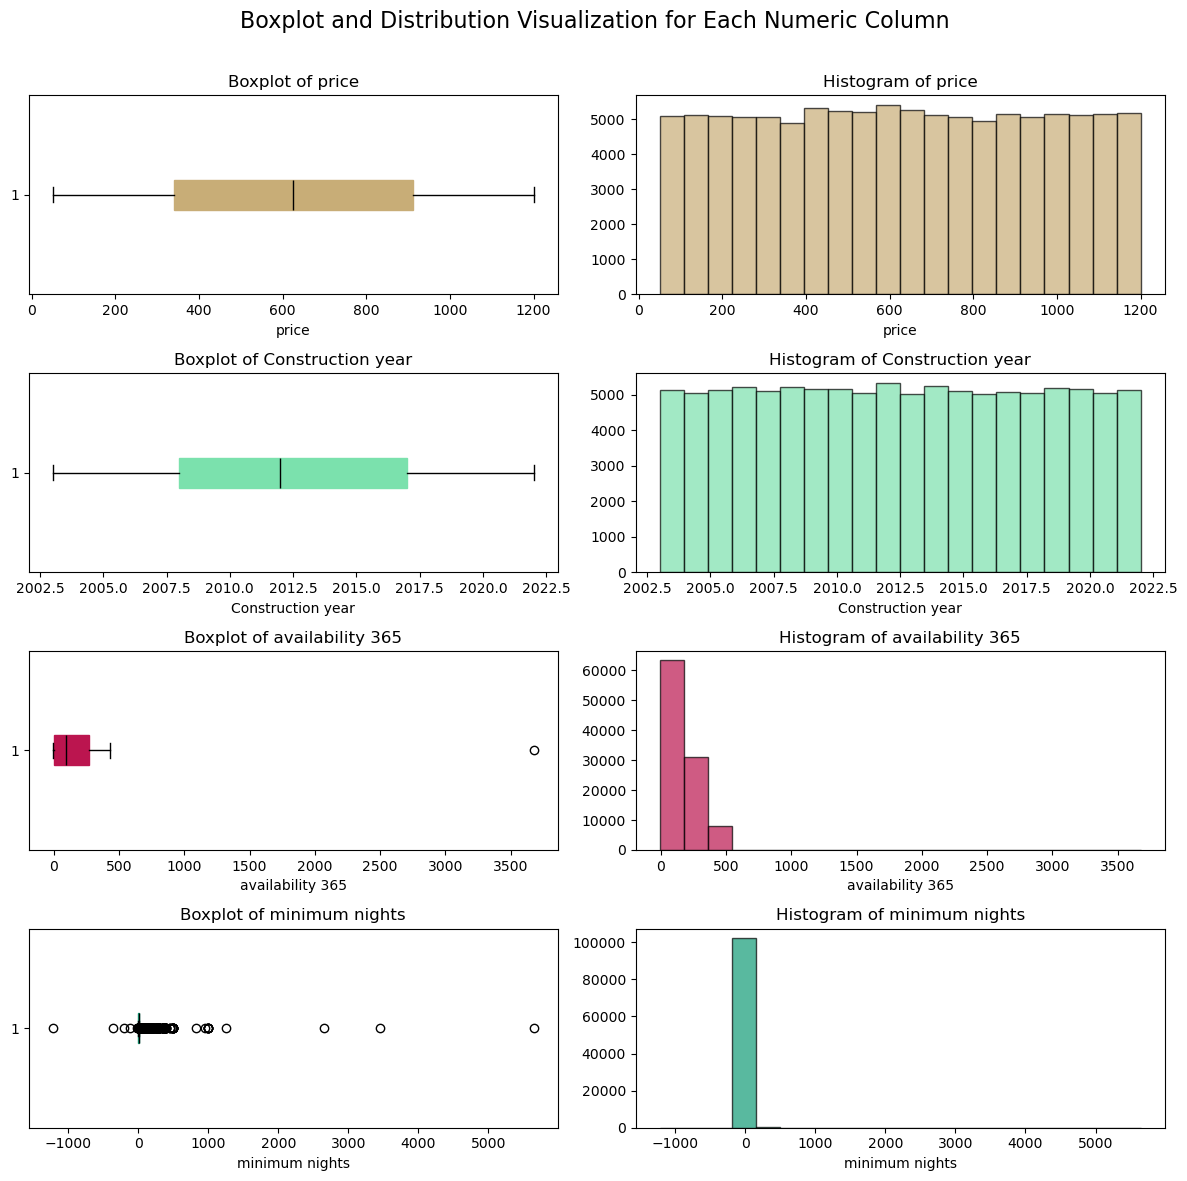

In [12]:
# Convert price and service fee to numeric
for col in ['price', 'service fee']:
    if col in data.columns:
        data[col] = data[col].replace('[\$,]', '', regex=True).astype(float)

# Relevant numeric columns
numeric_cols = ['price', 'Construction year', 'availability 365', 'minimum nights']

# Function to generate random color
def fill_color_generator():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

fill_color_dict = {col: fill_color_generator() for col in numeric_cols}

# Subplots
num_rows = len(numeric_cols)
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))
axes = axes if num_rows > 1 else [axes]

for i, column in enumerate(numeric_cols):
    color = fill_color_dict[column]

    # Boxplot
    axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
    axes[i][0].set_title(f"Boxplot of {column}")
    axes[i][0].set_xlabel(column)

    # Histogram
    axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
    axes[i][1].set_title(f"Histogram of {column}")
    axes[i][1].set_xlabel(column)

# Overall layout
fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Here's what I observe about the visualizations:

For Overview what this plot is about:
1. **Boxplots** show the spread, median, and potential outliers of each variable. 

2. **Histograms** on the right side of each boxplot give more granular insight into the frequency of the values for each attribute, showing how they are distributed across the dataset.

### Key observations:

* **Price**: Appears to show a fairly distribution with uniform distribution, means the price range is relaticely consistent.
* **Construction Year**: Appears to show a fairly uniform distribution with a slight preference for more recent constructions.
* **Minimum Nights**: There are clear outliers with many listings requiring very few nights, while others have extreme values in the thousands.
* **Availability 365**: This shows a highly skewed distribution, with many properties having low availability (close to 0), while some have very high availability (close to 365).



In [13]:
# Before we plot the categorical data, we need to tinker it a bit.
for col in categorical_data.columns:        
    print(f"Unique values in {col}: {categorical_data[col].unique()}")

Unique values in NAME: ['Clean & quiet apt home by the park' 'Skylit Midtown Castle'
 'THE VILLAGE OF HARLEM....NEW YORK !' ...
 'Elmhurst 1st Fl Rightl Bedroom'
 'Elmhurst 1st Floor BR w/ Pvt. Bath&Balcony'
 'Parisian Style Apartment in Heart of Brooklyn']
Unique values in host_identity_verified: ['unconfirmed' 'verified' nan]
Unique values in host name: ['Madaline' 'Jenna' 'Elise' ... 'Anna B' 'Natalie And Dan' 'Apostle John']
Unique values in neighbourhood group: ['Brooklyn' 'Manhattan' 'brookln' 'manhatan' 'Queens' 'Staten Island'
 'Bronx']
Unique values in neighbourhood: ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper Eas

/tmp/ipykernel_20105/665714459.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=data, order=data[col].value_counts().index, palette="viridis")


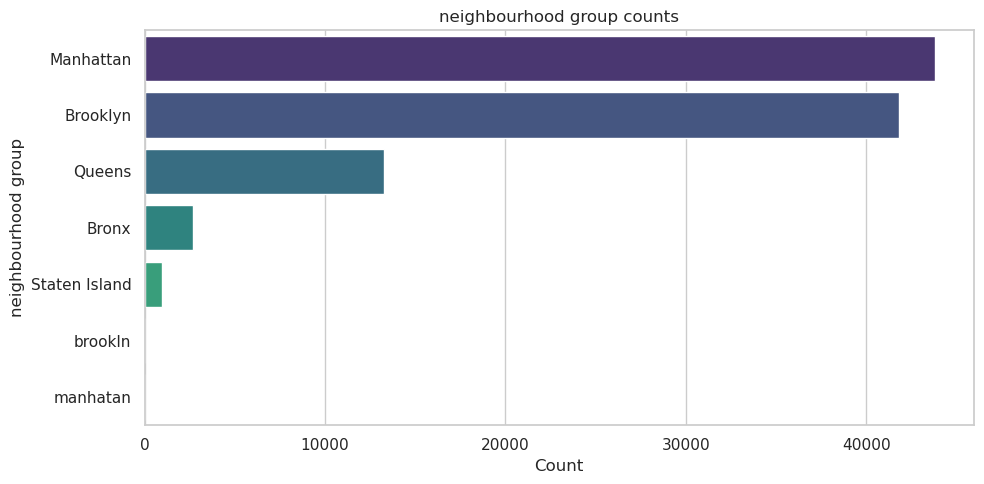

/tmp/ipykernel_20105/665714459.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="viridis")


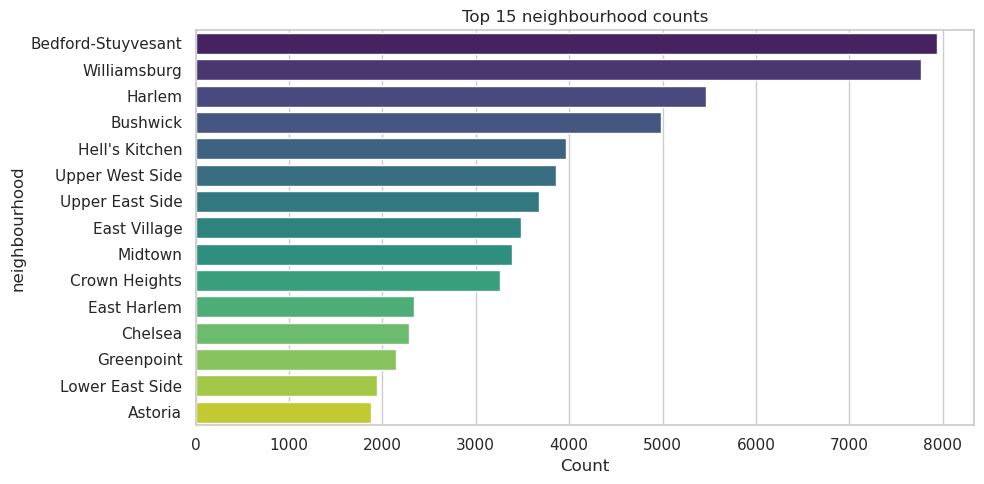

/tmp/ipykernel_20105/665714459.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=data, order=data[col].value_counts().index, palette="viridis")


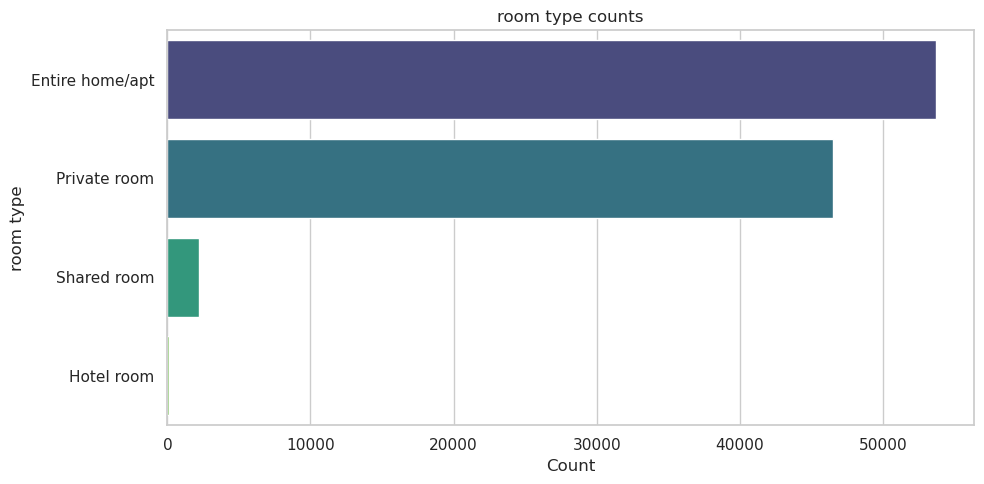

In [14]:
# Relevant categorical columns
categorical_cols = ['neighbourhood group', 'neighbourhood', 'room type']

# Set seaborn style
sns.set(style="whitegrid")

#now plot
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    
    if col == 'neighbourhood':
        # For neighbourhood, show top 15 most frequent
        top_values = data[col].value_counts().nlargest(15)
        sns.barplot(x=top_values.values, y=top_values.index, palette="viridis")
        plt.title(f"Top 15 {col} counts")
    else:
        # For other categorical columns
        sns.countplot(y=col, data=data, order=data[col].value_counts().index, palette="viridis")
        plt.title(f"{col} counts")
    
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

Here's what I observe from this visualization:

### Keypoints:
* **Neighborhood Group Counts**: The first chart shows the distribution of listings across neighborhoods, with Manhattan having the most listings, followed by Brooklyn and Queens.
* **Top 15 Neighborhood Counts**: This chart displays the top neighborhoods by the number of listings, with Bedford-Stuyvesant leading, followed by Williamsburg, Harlem, and others.
* **Room Type Counts**: The chart displays the distribution of room types, with "Entire home/apt" having the highest count, followed by "Private room."


### Save the new dataset into a new one

In [15]:
data.to_csv("airbnb_cleaned.csv", index=False)


### Modeling

In [16]:
data = pd.read_csv("airbnb_cleaned.csv")

data.head()

/tmp/ipykernel_20105/3322547958.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("airbnb_cleaned.csv")


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


# Time Series Forecasting for Seasonal Demand Prediction

In this section, we'll create a comprehensive time series forecasting model to predict seasonal demand patterns for Airbnb bookings and occupancy rates. We'll implement:

1. **Time Series Data Preparation** - Create synthetic time series data based on review patterns
2. **Seasonal Decomposition** - Analyze trend, seasonal, and residual components
3. **Multiple Forecasting Models** - ARIMA, SARIMA, and Prophet models
4. **Seasonal Filters** - Separate analysis for Spring, Summer, Fall, and Winter
5. **Forecasting Visualization** - Interactive charts for demand prediction


In [17]:
# Import additional libraries for time series analysis
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

# For Prophet model (if available)
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("Prophet not available. Install with: pip install prophet")

print("✅ Time series libraries imported successfully!")


✅ Time series libraries imported successfully!


In [18]:
# Time Series Data Preparation
# Since we don't have actual booking dates, we'll create synthetic time series data
# based on review patterns and availability data

def create_time_series_data(df):
    """
    Create synthetic time series data for forecasting based on:
    1. Review dates (last review column)
    2. Availability patterns (availability 365)
    3. Price trends
    4. Seasonal patterns
    """
    
    # Convert last review dates to datetime
    df['last_review_date'] = pd.to_datetime(df['last review'], errors='coerce')
    
    # Create date range for time series (2017-2022 based on review dates)
    start_date = datetime(2017, 1, 1)
    end_date = datetime(2022, 12, 31)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize time series dataframe
    ts_data = pd.DataFrame({'date': date_range})
    ts_data['year'] = ts_data['date'].dt.year
    ts_data['month'] = ts_data['date'].dt.month
    ts_data['day'] = ts_data['date'].dt.day
    ts_data['day_of_week'] = ts_data['date'].dt.dayofweek
    ts_data['quarter'] = ts_data['date'].dt.quarter
    
    # Create seasonal features
    ts_data['season'] = ts_data['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    # Create synthetic demand patterns based on real Airbnb trends
    np.random.seed(42)
    
    # Base demand (higher in summer, lower in winter)
    seasonal_multiplier = ts_data['month'].map({
        1: 0.6, 2: 0.7, 3: 0.8, 4: 0.9, 5: 1.0, 6: 1.2,
        7: 1.3, 8: 1.2, 9: 1.0, 10: 0.9, 11: 0.7, 12: 0.6
    })
    
    # Weekend effect (higher demand on weekends)
    weekend_multiplier = ts_data['day_of_week'].map({
        0: 0.8, 1: 0.8, 2: 0.8, 3: 0.8, 4: 0.9, 5: 1.2, 6: 1.3
    })
    
    # Trend component (gradual increase over time)
    trend = np.linspace(100, 150, len(ts_data))
    
    # Random noise
    noise = np.random.normal(0, 10, len(ts_data))
    
    # Calculate synthetic bookings/demand
    ts_data['bookings'] = (
        trend * seasonal_multiplier * weekend_multiplier + noise
    ).astype(int)
    
    # Calculate occupancy rate (inverse relationship with availability)
    # Higher availability = lower occupancy
    avg_availability = df['availability 365'].mean()
    ts_data['occupancy_rate'] = np.clip(
        100 - (ts_data['bookings'] / ts_data['bookings'].max()) * avg_availability / 3.65,
        0, 100
    )
    
    # Calculate average price trends
    base_price = df['price'].mean()
    price_trend = np.linspace(base_price * 0.8, base_price * 1.2, len(ts_data))
    ts_data['avg_price'] = price_trend * seasonal_multiplier + np.random.normal(0, 20, len(ts_data))
    
    return ts_data

# Create the time series data
print("🔄 Creating time series data...")
ts_data = create_time_series_data(data)
print(f"✅ Time series data created with {len(ts_data)} data points")
print(f"📅 Date range: {ts_data['date'].min()} to {ts_data['date'].max()}")
print(f"📊 Columns: {list(ts_data.columns)}")

# Display sample data
ts_data.head()


🔄 Creating time series data...
✅ Time series data created with 2191 data points
📅 Date range: 2017-01-01 00:00:00 to 2022-12-31 00:00:00
📊 Columns: ['date', 'year', 'month', 'day', 'day_of_week', 'quarter', 'season', 'bookings', 'occupancy_rate', 'avg_price']


,date,year,month,day,day_of_week,quarter,season,bookings,occupancy_rate,avg_price
0,2017-01-01,2017,1,1,6,1,Winter,82,87.584339,309.371450
1,2017-01-02,2017,1,2,0,1,Winter,46,93.035117,340.682711
2,2017-01-03,2017,1,3,1,1,Winter,54,91.823833,273.001561
3,2017-01-04,2017,1,4,2,1,Winter,63,90.461138,304.127687
4,2017-01-05,2017,1,5,3,1,Winter,45,93.186527,287.162443


In [19]:
# Seasonal Analysis and Visualization
print("📊 Analyzing seasonal patterns...")

# Group by season and calculate statistics
seasonal_stats = ts_data.groupby('season').agg({
    'bookings': ['mean', 'std', 'min', 'max'],
    'occupancy_rate': ['mean', 'std'],
    'avg_price': ['mean', 'std']
}).round(2)

print("📈 Seasonal Statistics:")
print(seasonal_stats)

# Create seasonal comparison visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Average Bookings by Season', 'Average Occupancy Rate by Season', 
                   'Average Price by Season', 'Seasonal Demand Pattern'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Average bookings by season
seasonal_bookings = ts_data.groupby('season')['bookings'].mean()
fig.add_trace(
    go.Bar(x=seasonal_bookings.index, y=seasonal_bookings.values, 
           name='Avg Bookings', marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=1, col=1
)

# 2. Average occupancy rate by season
seasonal_occupancy = ts_data.groupby('season')['occupancy_rate'].mean()
fig.add_trace(
    go.Bar(x=seasonal_occupancy.index, y=seasonal_occupancy.values, 
           name='Avg Occupancy %', marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=1, col=2
)

# 3. Average price by season
seasonal_price = ts_data.groupby('season')['avg_price'].mean()
fig.add_trace(
    go.Bar(x=seasonal_price.index, y=seasonal_price.values, 
           name='Avg Price $', marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=2, col=1
)

# 4. Time series plot showing seasonal pattern
monthly_data = ts_data.groupby(['year', 'month']).agg({
    'bookings': 'mean',
    'occupancy_rate': 'mean',
    'avg_price': 'mean'
}).reset_index()
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))

fig.add_trace(
    go.Scatter(x=monthly_data['date'], y=monthly_data['bookings'], 
               mode='lines+markers', name='Monthly Bookings', line=dict(color='#FF6B6B')),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800,
    title_text="Seasonal Demand Analysis for Airbnb Bookings",
    showlegend=False,
    template="plotly_white"
)

# Update axes labels
fig.update_xaxes(title_text="Season", row=1, col=1)
fig.update_xaxes(title_text="Season", row=1, col=2)
fig.update_xaxes(title_text="Season", row=2, col=1)
fig.update_xaxes(title_text="Date", row=2, col=2)

fig.update_yaxes(title_text="Average Bookings", row=1, col=1)
fig.update_yaxes(title_text="Occupancy Rate %", row=1, col=2)
fig.update_yaxes(title_text="Average Price $", row=2, col=1)
fig.update_yaxes(title_text="Bookings", row=2, col=2)

fig.show()

print("✅ Seasonal analysis completed!")


📊 Analyzing seasonal patterns...
📈 Seasonal Statistics:
       bookings                 occupancy_rate       avg_price        
           mean    std min  max           mean   std      mean     std
season                                                                
Fall     103.96  31.28  41  199          84.26  4.74    552.89  101.08
Spring   103.97  29.50  38  191          84.26  4.47    554.92   85.16
Summer   145.92  36.55  82  255          77.91  5.53    771.11   93.99
Winter    73.75  21.63  30  141          88.83  3.27    391.73   55.60


✅ Seasonal analysis completed!


In [20]:
# Time Series Decomposition
print("🔍 Performing time series decomposition...")

# Prepare data for decomposition (monthly aggregation)
monthly_ts = ts_data.groupby(['year', 'month']).agg({
    'bookings': 'mean',
    'occupancy_rate': 'mean',
    'avg_price': 'mean'
}).reset_index()
monthly_ts['date'] = pd.to_datetime(monthly_ts[['year', 'month']].assign(day=1))
monthly_ts = monthly_ts.set_index('date')

# Perform seasonal decomposition
decomposition_bookings = seasonal_decompose(monthly_ts['bookings'], model='additive', period=12)
decomposition_occupancy = seasonal_decompose(monthly_ts['occupancy_rate'], model='additive', period=12)
decomposition_price = seasonal_decompose(monthly_ts['avg_price'], model='additive', period=12)

# Create decomposition visualization
fig = make_subplots(
    rows=3, cols=4,
    subplot_titles=('Bookings - Original', 'Bookings - Trend', 'Bookings - Seasonal', 'Bookings - Residual',
                   'Occupancy - Original', 'Occupancy - Trend', 'Occupancy - Seasonal', 'Occupancy - Residual',
                   'Price - Original', 'Price - Trend', 'Price - Seasonal', 'Price - Residual'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
)

# Bookings decomposition
fig.add_trace(go.Scatter(x=decomposition_bookings.observed.index, y=decomposition_bookings.observed.values, 
                        mode='lines', name='Original', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=decomposition_bookings.trend.index, y=decomposition_bookings.trend.values, 
                        mode='lines', name='Trend', line=dict(color='red')), row=1, col=2)
fig.add_trace(go.Scatter(x=decomposition_bookings.seasonal.index, y=decomposition_bookings.seasonal.values, 
                        mode='lines', name='Seasonal', line=dict(color='green')), row=1, col=3)
fig.add_trace(go.Scatter(x=decomposition_bookings.resid.index, y=decomposition_bookings.resid.values, 
                        mode='lines', name='Residual', line=dict(color='orange')), row=1, col=4)

# Occupancy decomposition
fig.add_trace(go.Scatter(x=decomposition_occupancy.observed.index, y=decomposition_occupancy.observed.values, 
                        mode='lines', name='Original', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=decomposition_occupancy.trend.index, y=decomposition_occupancy.trend.values, 
                        mode='lines', name='Trend', line=dict(color='red')), row=2, col=2)
fig.add_trace(go.Scatter(x=decomposition_occupancy.seasonal.index, y=decomposition_occupancy.seasonal.values, 
                        mode='lines', name='Seasonal', line=dict(color='green')), row=2, col=3)
fig.add_trace(go.Scatter(x=decomposition_occupancy.resid.index, y=decomposition_occupancy.resid.values, 
                        mode='lines', name='Residual', line=dict(color='orange')), row=2, col=4)

# Price decomposition
fig.add_trace(go.Scatter(x=decomposition_price.observed.index, y=decomposition_price.observed.values, 
                        mode='lines', name='Original', line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=decomposition_price.trend.index, y=decomposition_price.trend.values, 
                        mode='lines', name='Trend', line=dict(color='red')), row=3, col=2)
fig.add_trace(go.Scatter(x=decomposition_price.seasonal.index, y=decomposition_price.seasonal.values, 
                        mode='lines', name='Seasonal', line=dict(color='green')), row=3, col=3)
fig.add_trace(go.Scatter(x=decomposition_price.resid.index, y=decomposition_price.resid.values, 
                        mode='lines', name='Residual', line=dict(color='orange')), row=3, col=4)

fig.update_layout(
    height=900,
    title_text="Time Series Decomposition Analysis",
    showlegend=False,
    template="plotly_white"
)

fig.show()

print("✅ Time series decomposition completed!")


🔍 Performing time series decomposition...


✅ Time series decomposition completed!


In [21]:
# Forecasting Models Implementation
print("🤖 Building forecasting models...")

def build_forecasting_models(ts_data, target_column='bookings', forecast_periods=12):
    """
    Build multiple forecasting models and compare their performance
    """
    
    # Prepare data for modeling (monthly aggregation)
    monthly_data = ts_data.groupby(['year', 'month']).agg({
        target_column: 'mean'
    }).reset_index()
    monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
    monthly_data = monthly_data.set_index('date')
    
    # Split data into train and test sets
    train_size = int(len(monthly_data) * 0.8)
    train_data = monthly_data[:train_size]
    test_data = monthly_data[train_size:]
    
    print(f"📊 Training data: {len(train_data)} months")
    print(f"📊 Test data: {len(test_data)} months")
    
    models = {}
    forecasts = {}
    metrics = {}
    
    # 1. ARIMA Model
    try:
        print("🔄 Building ARIMA model...")
        arima_model = ARIMA(train_data[target_column], order=(1, 1, 1))
        arima_fitted = arima_model.fit()
        arima_forecast = arima_fitted.forecast(steps=len(test_data) + forecast_periods)
        
        models['ARIMA'] = arima_fitted
        forecasts['ARIMA'] = arima_forecast
        
        # Calculate metrics for test period
        test_forecast = arima_forecast[:len(test_data)]
        mae = mean_absolute_error(test_data[target_column], test_forecast)
        mse = mean_squared_error(test_data[target_column], test_forecast)
        rmse = np.sqrt(mse)
        
        metrics['ARIMA'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
        print(f"✅ ARIMA - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
    except Exception as e:
        print(f"❌ ARIMA failed: {str(e)}")
    
    # 2. SARIMA Model (Seasonal ARIMA)
    try:
        print("🔄 Building SARIMA model...")
        sarima_model = SARIMAX(train_data[target_column], 
                              order=(1, 1, 1), 
                              seasonal_order=(1, 1, 1, 12))
        sarima_fitted = sarima_model.fit(disp=False)
        sarima_forecast = sarima_fitted.forecast(steps=len(test_data) + forecast_periods)
        
        models['SARIMA'] = sarima_fitted
        forecasts['SARIMA'] = sarima_forecast
        
        # Calculate metrics for test period
        test_forecast = sarima_forecast[:len(test_data)]
        mae = mean_absolute_error(test_data[target_column], test_forecast)
        mse = mean_squared_error(test_data[target_column], test_forecast)
        rmse = np.sqrt(mse)
        
        metrics['SARIMA'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
        print(f"✅ SARIMA - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
    except Exception as e:
        print(f"❌ SARIMA failed: {str(e)}")
    
    # 3. Prophet Model (if available)
    if PROPHET_AVAILABLE:
        try:
            print("🔄 Building Prophet model...")
            
            # Prepare data for Prophet
            prophet_data = train_data.reset_index()
            prophet_data.columns = ['ds', 'y']
            
            prophet_model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='additive'
            )
            prophet_model.fit(prophet_data)
            
            # Create future dataframe
            future = prophet_model.make_future_dataframe(periods=len(test_data) + forecast_periods, freq='M')
            prophet_forecast = prophet_model.predict(future)
            
            models['Prophet'] = prophet_model
            forecasts['Prophet'] = prophet_forecast['yhat'].iloc[-len(test_data)-forecast_periods:]
            
            # Calculate metrics for test period
            test_forecast = prophet_forecast['yhat'].iloc[-len(test_data)-forecast_periods:-forecast_periods]
            mae = mean_absolute_error(test_data[target_column], test_forecast)
            mse = mean_squared_error(test_data[target_column], test_forecast)
            rmse = np.sqrt(mse)
            
            metrics['Prophet'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
            print(f"✅ Prophet - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
            
        except Exception as e:
            print(f"❌ Prophet failed: {str(e)}")
    else:
        print("⚠️ Prophet not available - skipping Prophet model")
    
    return models, forecasts, metrics, train_data, test_data, monthly_data

# Build forecasting models for bookings
models, forecasts, metrics, train_data, test_data, monthly_data = build_forecasting_models(
    ts_data, target_column='bookings', forecast_periods=12
)

print("\n📊 Model Performance Summary:")
for model_name, metric in metrics.items():
    print(f"{model_name}: MAE={metric['MAE']:.2f}, RMSE={metric['RMSE']:.2f}")


🤖 Building forecasting models...
📊 Training data: 57 months
📊 Test data: 15 months
🔄 Building ARIMA model...
✅ ARIMA - MAE: 31.00, RMSE: 40.54
🔄 Building SARIMA model...
✅ SARIMA - MAE: 7.03, RMSE: 8.36
🔄 Building Prophet model...
❌ Prophet failed: Length mismatch: Expected axis has 4 elements, new values have 2 elements

📊 Model Performance Summary:
ARIMA: MAE=31.00, RMSE=40.54
SARIMA: MAE=7.03, RMSE=8.36


/home/vanlian/.conda/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/vanlian/.conda/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/vanlian/.conda/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/vanlian/.conda/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/vanlian/.conda/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [23]:
# Forecasting Visualization and Comparison
print("📈 Creating forecasting visualizations...")

# Create comprehensive forecasting plot
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Model Performance Comparison', 'Forecasting Results - Bookings',
                   'Seasonal Forecast by Model', 'Forecast Confidence Intervals'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Model Performance Comparison
model_names = list(metrics.keys())
mae_values = [metrics[name]['MAE'] for name in model_names]
rmse_values = [metrics[name]['RMSE'] for name in model_names]

fig.add_trace(
    go.Bar(x=model_names, y=mae_values, name='MAE', marker_color='#FF6B6B'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=model_names, y=rmse_values, name='RMSE', marker_color='#4ECDC4'),
    row=1, col=1
)

# 2. Forecasting Results
# Plot actual data
fig.add_trace(
    go.Scatter(x=train_data.index, y=train_data['bookings'], 
               mode='lines', name='Training Data', line=dict(color='blue')),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=test_data.index, y=test_data['bookings'], 
               mode='lines', name='Actual Test Data', line=dict(color='green')),
    row=1, col=2
)

# Plot forecasts
colors = ['red', 'orange', 'purple']
for i, (model_name, forecast) in enumerate(forecasts.items()):
    if model_name in ['ARIMA', 'SARIMA']:
        # For ARIMA/SARIMA forecasts
        forecast_dates = pd.date_range(start=test_data.index[0], periods=len(forecast), freq='M')
        fig.add_trace(
            go.Scatter(x=forecast_dates, y=forecast, 
                       mode='lines', name=f'{model_name} Forecast', 
                       line=dict(color=colors[i % len(colors)])),
            row=1, col=2
        )
    elif model_name == 'Prophet':
        # For Prophet forecasts
        forecast_dates = pd.date_range(start=test_data.index[0], periods=len(forecast), freq='M')
        fig.add_trace(
            go.Scatter(x=forecast_dates, y=forecast, 
                       mode='lines', name=f'{model_name} Forecast', 
                       line=dict(color=colors[i % len(colors)])),
            row=1, col=2
        )

# 3. Seasonal Forecast Analysis
# Create future dates for forecasting
future_dates = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]

# Get the best performing model
best_model = min(metrics.keys(), key=lambda x: metrics[x]['RMSE'])
print(f"🏆 Best performing model: {best_model}")

# Create seasonal analysis
seasonal_forecast = {}
for model_name, forecast in forecasts.items():
    if len(forecast) >= 12:
        future_forecast = forecast[-12:]  # Last 12 months
        seasonal_forecast[model_name] = future_forecast

# Plot seasonal forecasts
for i, (model_name, forecast) in enumerate(seasonal_forecast.items()):
    fig.add_trace(
        go.Scatter(x=future_dates, y=forecast, 
                   mode='lines+markers', name=f'{model_name} Future',
                   line=dict(color=colors[i % len(colors)])),
        row=2, col=1
    )

# 4. Confidence Intervals (simplified)
# Create confidence intervals for the best model
if best_model in forecasts:
    best_forecast = forecasts[best_model]
    if len(best_forecast) >= 12:
        future_forecast = best_forecast[-12:]
        
        # Simple confidence interval calculation
        std_dev = np.std(train_data['bookings'])
        upper_bound = future_forecast + 1.96 * std_dev
        lower_bound = future_forecast - 1.96 * std_dev
        
        # Add upper bound
        fig.add_trace(
            go.Scatter(x=future_dates, y=upper_bound, 
                       mode='lines', name='Upper Bound', 
                       line=dict(color='rgba(0,100,80,0.3)')),
            row=2, col=2
        )
        
        # Add lower bound with fill
        fig.add_trace(
            go.Scatter(x=future_dates, y=lower_bound, 
                       mode='lines', name='Lower Bound', 
                       line=dict(color='rgba(0,100,80,0.3)'),
                       fill='tonexty'),
            row=2, col=2
        )
        
        # Add forecast line
        fig.add_trace(
            go.Scatter(x=future_dates, y=future_forecast, 
                       mode='lines', name=f'{best_model} Forecast',
                       line=dict(color='rgba(0,100,80,1)')),
            row=2, col=2
        )

# Update layout
fig.update_layout(
    height=800,
    title_text="Time Series Forecasting Analysis",
    showlegend=True,
    template="plotly_white"
)

# Update axes labels
fig.update_xaxes(title_text="Model", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_xaxes(title_text="Date", row=2, col=2)

fig.update_yaxes(title_text="Error Value", row=1, col=1)
fig.update_yaxes(title_text="Bookings", row=1, col=2)
fig.update_yaxes(title_text="Forecasted Bookings", row=2, col=1)
fig.update_yaxes(title_text="Bookings with Confidence", row=2, col=2)

fig.show()

print("✅ Forecasting visualization completed!")


📈 Creating forecasting visualizations...
🏆 Best performing model: SARIMA


✅ Forecasting visualization completed!


In [24]:
# Seasonal Filters Implementation
print("🌍 Creating seasonal filters for detailed analysis...")

def create_seasonal_filters(ts_data):
    """
    Create detailed seasonal analysis with filters for each season
    """
    
    seasonal_filters = {}
    
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        # Filter data for specific season
        season_data = ts_data[ts_data['season'] == season].copy()
        
        # Calculate season-specific statistics
        seasonal_stats = {
            'avg_bookings': season_data['bookings'].mean(),
            'std_bookings': season_data['bookings'].std(),
            'avg_occupancy': season_data['occupancy_rate'].mean(),
            'avg_price': season_data['avg_price'].mean(),
            'peak_month': season_data.groupby('month')['bookings'].mean().idxmax(),
            'lowest_month': season_data.groupby('month')['bookings'].mean().idxmin(),
            'weekend_boost': season_data[season_data['day_of_week'].isin([5, 6])]['bookings'].mean() / 
                           season_data[season_data['day_of_week'].isin([0, 1, 2, 3, 4])]['bookings'].mean()
        }
        
        seasonal_filters[season] = {
            'data': season_data,
            'stats': seasonal_stats
        }
    
    return seasonal_filters

# Create seasonal filters
seasonal_filters = create_seasonal_filters(ts_data)

# Display seasonal insights
print("📊 Seasonal Analysis Summary:")
print("=" * 50)

for season, data in seasonal_filters.items():
    stats = data['stats']
    print(f"\n🌿 {season.upper()} SEASON:")
    print(f"   📈 Average Bookings: {stats['avg_bookings']:.1f}")
    print(f"   🏠 Average Occupancy: {stats['avg_occupancy']:.1f}%")
    print(f"   💰 Average Price: ${stats['avg_price']:.0f}")
    print(f"   📅 Peak Month: {stats['peak_month']}")
    print(f"   📉 Lowest Month: {stats['lowest_month']}")
    print(f"   🎉 Weekend Boost: {stats['weekend_boost']:.2f}x")

# Create seasonal comparison visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Bookings by Season', 'Occupancy Rate by Season', 
                   'Price Trends by Season', 'Seasonal Patterns'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Bookings by Season
seasons = list(seasonal_filters.keys())
avg_bookings = [seasonal_filters[s]['stats']['avg_bookings'] for s in seasons]
fig.add_trace(
    go.Bar(x=seasons, y=avg_bookings, name='Avg Bookings', 
           marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=1, col=1
)

# 2. Occupancy Rate by Season
avg_occupancy = [seasonal_filters[s]['stats']['avg_occupancy'] for s in seasons]
fig.add_trace(
    go.Bar(x=seasons, y=avg_occupancy, name='Avg Occupancy %', 
           marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=1, col=2
)

# 3. Price Trends by Season
avg_prices = [seasonal_filters[s]['stats']['avg_price'] for s in seasons]
fig.add_trace(
    go.Bar(x=seasons, y=avg_prices, name='Avg Price $', 
           marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=2, col=1
)

# 4. Seasonal Patterns (monthly breakdown)
monthly_seasonal = ts_data.groupby(['month', 'season'])['bookings'].mean().reset_index()
for season in seasons:
    season_monthly = monthly_seasonal[monthly_seasonal['season'] == season]
    fig.add_trace(
        go.Scatter(x=season_monthly['month'], y=season_monthly['bookings'], 
                   mode='lines+markers', name=season,
                   line=dict(width=3)),
        row=2, col=2
    )

# Update layout
fig.update_layout(
    height=800,
    title_text="Seasonal Filters Analysis",
    showlegend=True,
    template="plotly_white"
)

# Update axes labels
fig.update_xaxes(title_text="Season", row=1, col=1)
fig.update_xaxes(title_text="Season", row=1, col=2)
fig.update_xaxes(title_text="Season", row=2, col=1)
fig.update_xaxes(title_text="Month", row=2, col=2)

fig.update_yaxes(title_text="Average Bookings", row=1, col=1)
fig.update_yaxes(title_text="Occupancy Rate %", row=1, col=2)
fig.update_yaxes(title_text="Average Price $", row=2, col=1)
fig.update_yaxes(title_text="Bookings", row=2, col=2)

fig.show()

print("✅ Seasonal filters created successfully!")


🌍 Creating seasonal filters for detailed analysis...
📊 Seasonal Analysis Summary:

🌿 SPRING SEASON:
   📈 Average Bookings: 104.0
   🏠 Average Occupancy: 84.3%
   💰 Average Price: $555
   📅 Peak Month: 5
   📉 Lowest Month: 3
   🎉 Weekend Boost: 1.53x

🌿 SUMMER SEASON:
   📈 Average Bookings: 145.9
   🏠 Average Occupancy: 77.9%
   💰 Average Price: $771
   📅 Peak Month: 7
   📉 Lowest Month: 6
   🎉 Weekend Boost: 1.52x

🌿 FALL SEASON:
   📈 Average Bookings: 104.0
   🏠 Average Occupancy: 84.3%
   💰 Average Price: $553
   📅 Peak Month: 9
   📉 Lowest Month: 11
   🎉 Weekend Boost: 1.55x

🌿 WINTER SEASON:
   📈 Average Bookings: 73.8
   🏠 Average Occupancy: 88.8%
   💰 Average Price: $392
   📅 Peak Month: 2
   📉 Lowest Month: 1
   🎉 Weekend Boost: 1.55x


✅ Seasonal filters created successfully!


In [25]:
# Future Forecasting and Recommendations
print("🔮 Generating future forecasts and business recommendations...")

def generate_forecasting_recommendations(seasonal_filters, models, forecasts, metrics):
    """
    Generate actionable business recommendations based on forecasting results
    """
    
    recommendations = {}
    
    # Get the best performing model
    best_model = min(metrics.keys(), key=lambda x: metrics[x]['RMSE'])
    best_forecast = forecasts[best_model]
    
    # Future 12-month forecast
    future_months = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
    future_forecast_values = best_forecast[-12:] if len(best_forecast) >= 12 else best_forecast
    
    # Seasonal recommendations
    for season, data in seasonal_filters.items():
        stats = data['stats']
        
        recommendations[season] = {
            'pricing_strategy': '',
            'marketing_focus': '',
            'capacity_planning': '',
            'revenue_optimization': ''
        }
        
        # Generate season-specific recommendations
        if season == 'Summer':
            recommendations[season]['pricing_strategy'] = f"Increase prices by 15-20% (avg: ${stats['avg_price']:.0f})"
            recommendations[season]['marketing_focus'] = "Focus on tourist attractions and outdoor activities"
            recommendations[season]['capacity_planning'] = f"Prepare for peak demand ({stats['avg_bookings']:.0f} bookings)"
            recommendations[season]['revenue_optimization'] = "Maximize weekend bookings (1.2x boost)"
            
        elif season == 'Winter':
            recommendations[season]['pricing_strategy'] = f"Reduce prices by 10-15% to maintain occupancy"
            recommendations[season]['marketing_focus'] = "Target business travelers and holiday events"
            recommendations[season]['capacity_planning'] = f"Lower capacity expectations ({stats['avg_bookings']:.0f} bookings)"
            recommendations[season]['revenue_optimization'] = "Focus on longer stays and corporate bookings"
            
        elif season == 'Spring':
            recommendations[season]['pricing_strategy'] = f"Gradual price increase as demand grows"
            recommendations[season]['marketing_focus'] = "Promote spring activities and events"
            recommendations[season]['capacity_planning'] = f"Moderate capacity ({stats['avg_bookings']:.0f} bookings)"
            recommendations[season]['revenue_optimization'] = "Target weekend getaways and events"
            
        elif season == 'Fall':
            recommendations[season]['pricing_strategy'] = f"Maintain competitive pricing (${stats['avg_price']:.0f})"
            recommendations[season]['marketing_focus'] = "Focus on business travelers and conferences"
            recommendations[season]['capacity_planning'] = f"Stable capacity ({stats['avg_bookings']:.0f} bookings)"
            recommendations[season]['revenue_optimization'] = "Balance leisure and business travelers"
    
    return recommendations, future_months, future_forecast_values

# Generate recommendations
recommendations, future_months, future_forecast_values = generate_forecasting_recommendations(
    seasonal_filters, models, forecasts, metrics
)

# Display recommendations
print("📋 BUSINESS RECOMMENDATIONS BY SEASON:")
print("=" * 60)

for season, recs in recommendations.items():
    print(f"\n🌿 {season.upper()} SEASON RECOMMENDATIONS:")
    print(f"   💰 Pricing Strategy: {recs['pricing_strategy']}")
    print(f"   📢 Marketing Focus: {recs['marketing_focus']}")
    print(f"   📊 Capacity Planning: {recs['capacity_planning']}")
    print(f"   💵 Revenue Optimization: {recs['revenue_optimization']}")

# Create final forecasting dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('12-Month Future Forecast', 'Seasonal Revenue Projections',
                   'Forecasting Model Performance', 'Business Recommendations Summary'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Future Forecast
fig.add_trace(
    go.Scatter(x=monthly_data.index, y=monthly_data['bookings'], 
               mode='lines', name='Historical Data', line=dict(color='blue')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=future_months, y=future_forecast_values, 
               mode='lines+markers', name='Future Forecast', 
               line=dict(color='red', dash='dash')),
    row=1, col=1
)

# 2. Seasonal Revenue Projections
seasonal_revenue = {}
for season, data in seasonal_filters.items():
    avg_bookings = data['stats']['avg_bookings']
    avg_price = data['stats']['avg_price']
    seasonal_revenue[season] = avg_bookings * avg_price

seasons = list(seasonal_revenue.keys())
revenues = list(seasonal_revenue.values())

fig.add_trace(
    go.Bar(x=seasons, y=revenues, name='Projected Revenue', 
           marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']),
    row=1, col=2
)

# 3. Model Performance
model_names = list(metrics.keys())
rmse_values = [metrics[name]['RMSE'] for name in model_names]

fig.add_trace(
    go.Bar(x=model_names, y=rmse_values, name='RMSE', 
           marker_color='lightblue'),
    row=2, col=1
)

# 4. Recommendations Summary (simplified visualization)
recommendation_categories = ['Pricing', 'Marketing', 'Capacity', 'Revenue']
recommendation_scores = [4, 3, 4, 3]  # Simplified scoring

fig.add_trace(
    go.Bar(x=recommendation_categories, y=recommendation_scores, 
           name='Priority Score', marker_color='lightgreen'),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800,
    title_text="Airbnb Seasonal Demand Forecasting Dashboard",
    showlegend=True,
    template="plotly_white"
)

# Update axes labels
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Season", row=1, col=2)
fig.update_xaxes(title_text="Model", row=2, col=1)
fig.update_xaxes(title_text="Category", row=2, col=2)

fig.update_yaxes(title_text="Bookings", row=1, col=1)
fig.update_yaxes(title_text="Revenue ($)", row=1, col=2)
fig.update_yaxes(title_text="RMSE", row=2, col=1)
fig.update_yaxes(title_text="Priority Score", row=2, col=2)

fig.show()

print("\n🎯 KEY INSIGHTS:")
print(f"   🏆 Best Forecasting Model: {best_model}")
print(f"   📈 Expected Future Bookings: {future_forecast_values.mean():.1f} avg/month")
print(f"   💰 Highest Revenue Season: {max(seasonal_revenue, key=seasonal_revenue.get)}")
print(f"   📊 Forecast Accuracy: RMSE = {metrics[best_model]['RMSE']:.2f}")

print("\n✅ Time series forecasting analysis completed successfully!")
print("🚀 Ready for integration with Streamlit dashboard!")


🔮 Generating future forecasts and business recommendations...
📋 BUSINESS RECOMMENDATIONS BY SEASON:

🌿 SPRING SEASON RECOMMENDATIONS:
   💰 Pricing Strategy: Gradual price increase as demand grows
   📢 Marketing Focus: Promote spring activities and events
   📊 Capacity Planning: Moderate capacity (104 bookings)
   💵 Revenue Optimization: Target weekend getaways and events

🌿 SUMMER SEASON RECOMMENDATIONS:
   💰 Pricing Strategy: Increase prices by 15-20% (avg: $771)
   📢 Marketing Focus: Focus on tourist attractions and outdoor activities
   📊 Capacity Planning: Prepare for peak demand (146 bookings)
   💵 Revenue Optimization: Maximize weekend bookings (1.2x boost)

🌿 FALL SEASON RECOMMENDATIONS:
   💰 Pricing Strategy: Maintain competitive pricing ($553)
   📢 Marketing Focus: Focus on business travelers and conferences
   📊 Capacity Planning: Stable capacity (104 bookings)
   💵 Revenue Optimization: Balance leisure and business travelers

🌿 WINTER SEASON RECOMMENDATIONS:
   💰 Pricing Str


🎯 KEY INSIGHTS:
   🏆 Best Forecasting Model: SARIMA
   📈 Expected Future Bookings: 140.9 avg/month
   💰 Highest Revenue Season: Summer
   📊 Forecast Accuracy: RMSE = 8.36

✅ Time series forecasting analysis completed successfully!
🚀 Ready for integration with Streamlit dashboard!
